# Give Me Some Credit — Baseline Setup & Data Audit

Building a transparent, reproducible baseline to predict `SeriousDlqin2yrs` (default within 2 years).

**Data**
- 'dataset.csv'

In [73]:
# --- Reproducible environment & lightweight utilities ---
from __future__ import annotations

import os
from pathlib import Path
from dataclasses import dataclass
from typing import Iterable, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# --- Training utilities ---
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix, classification_report
)
from tqdm.auto import tqdm
import math
import os

# Plot defaults: consistent sizing and readable grids
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 140

# Keep the console clean from non-critical warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Reproducibility
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Project paths
DATASET_PATH = "../data/dataset.csv"
MODEL_PATH = "../models"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


## Load raw data & quick inspection

Loading the dataset from `../data/`, previewing rows, and checking dtypes/nulls.  
This confirms file access, column names, and highlights obvious data issues before defining any schema.

In [2]:
# load dataset
df = pd.read_csv(DATASET_PATH)

In [4]:
# Shapes and a quick peek
print(f"dataset shape: {df.shape}")
display(df.head(5))

# Structural info (dtypes + non-null counts)
df.info()

# ─────────────────────────────────────────────────────
# Missing values and descriptive statistics
# ─────────────────────────────────────────────────────
# Missing per column (training)
display(df.isna().sum().to_frame("missing").T)

# Numeric descriptives
display(df.describe(include=[np.number]).T)

dataset shape: (150000, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
missing,0,0,0,0,0,0,29731,0,0,0,0,3924


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


In [5]:
df.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

## Schema cleanup

- Drop the technical index column `Unnamed: 0`.
- Ensure the target `SeriousDlqin2yrs` is the **last** column.
- Define `FEATURES` (ordered) and `TARGET` to lock the schema for the rest of the pipeline.
- Add sanity checks to avoid silent drift.

In [11]:
TARGET = "SeriousDlqin2yrs"
# 1) Remove technical index column if present
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# 2) Reorder so target is last
feature_cols = [c for c in df.columns if c != TARGET]
df = df[feature_cols + [TARGET]]
# Preview to confirm visually
display(df.head(3))

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0


## Train/Validation/Test split (no leakage)

Data is split before any preprocessing:

1. Stratified split to preserve the target distribution.
2. Fit preprocessing only on the training split.
3. Transform validation/test using the fitted preprocessing.
4. Convert to tensors and wrap with a lightweight `Dataset` + `DataLoader`.

This order prevents information leakage from validation/test into training-time statistics.

In [13]:
from sklearn.model_selection import train_test_split

# Ratios 
TEST_SIZE = 0.15
VAL_SIZE  = 0.15   # of the remaining after test split

In [14]:
# Train/Test split
df_train, df_test = train_test_split(
    df,
    test_size=TEST_SIZE,
    stratify=df[TARGET], # keep (approx.) the same class proportions in each split
    random_state=RNG_SEED,
)

# Train/Val split
df_train, df_val = train_test_split(
    df_train,
    test_size=VAL_SIZE,
    stratify=df_train[TARGET], # keep (approx.) the same class proportions in each split
    random_state=RNG_SEED,
)

In [15]:
def _balance(y):
    vc = y.value_counts().sort_index()
    n = int(vc.sum())
    return {int(k): f"{int(v)} ({100*v/n:.2f}%)" for k, v in vc.items()}

print("Shapes:")
print("  train:", df_train.shape)
print("  val  :", df_val.shape)
print("  test :", df_test.shape)

print("\nTarget balance:")
print("  train:", _balance(df_train[TARGET]))
print("  val  :", _balance(df_val[TARGET]))
print("  test :", _balance(df_test[TARGET]))

Shapes:
  train: (108375, 11)
  val  : (19125, 11)
  test : (22500, 11)

Target balance:
  train: {0: '101131 (93.32%)', 1: '7244 (6.68%)'}
  val  : {0: '17847 (93.32%)', 1: '1278 (6.68%)'}
  test : {0: '20996 (93.32%)', 1: '1504 (6.68%)'}


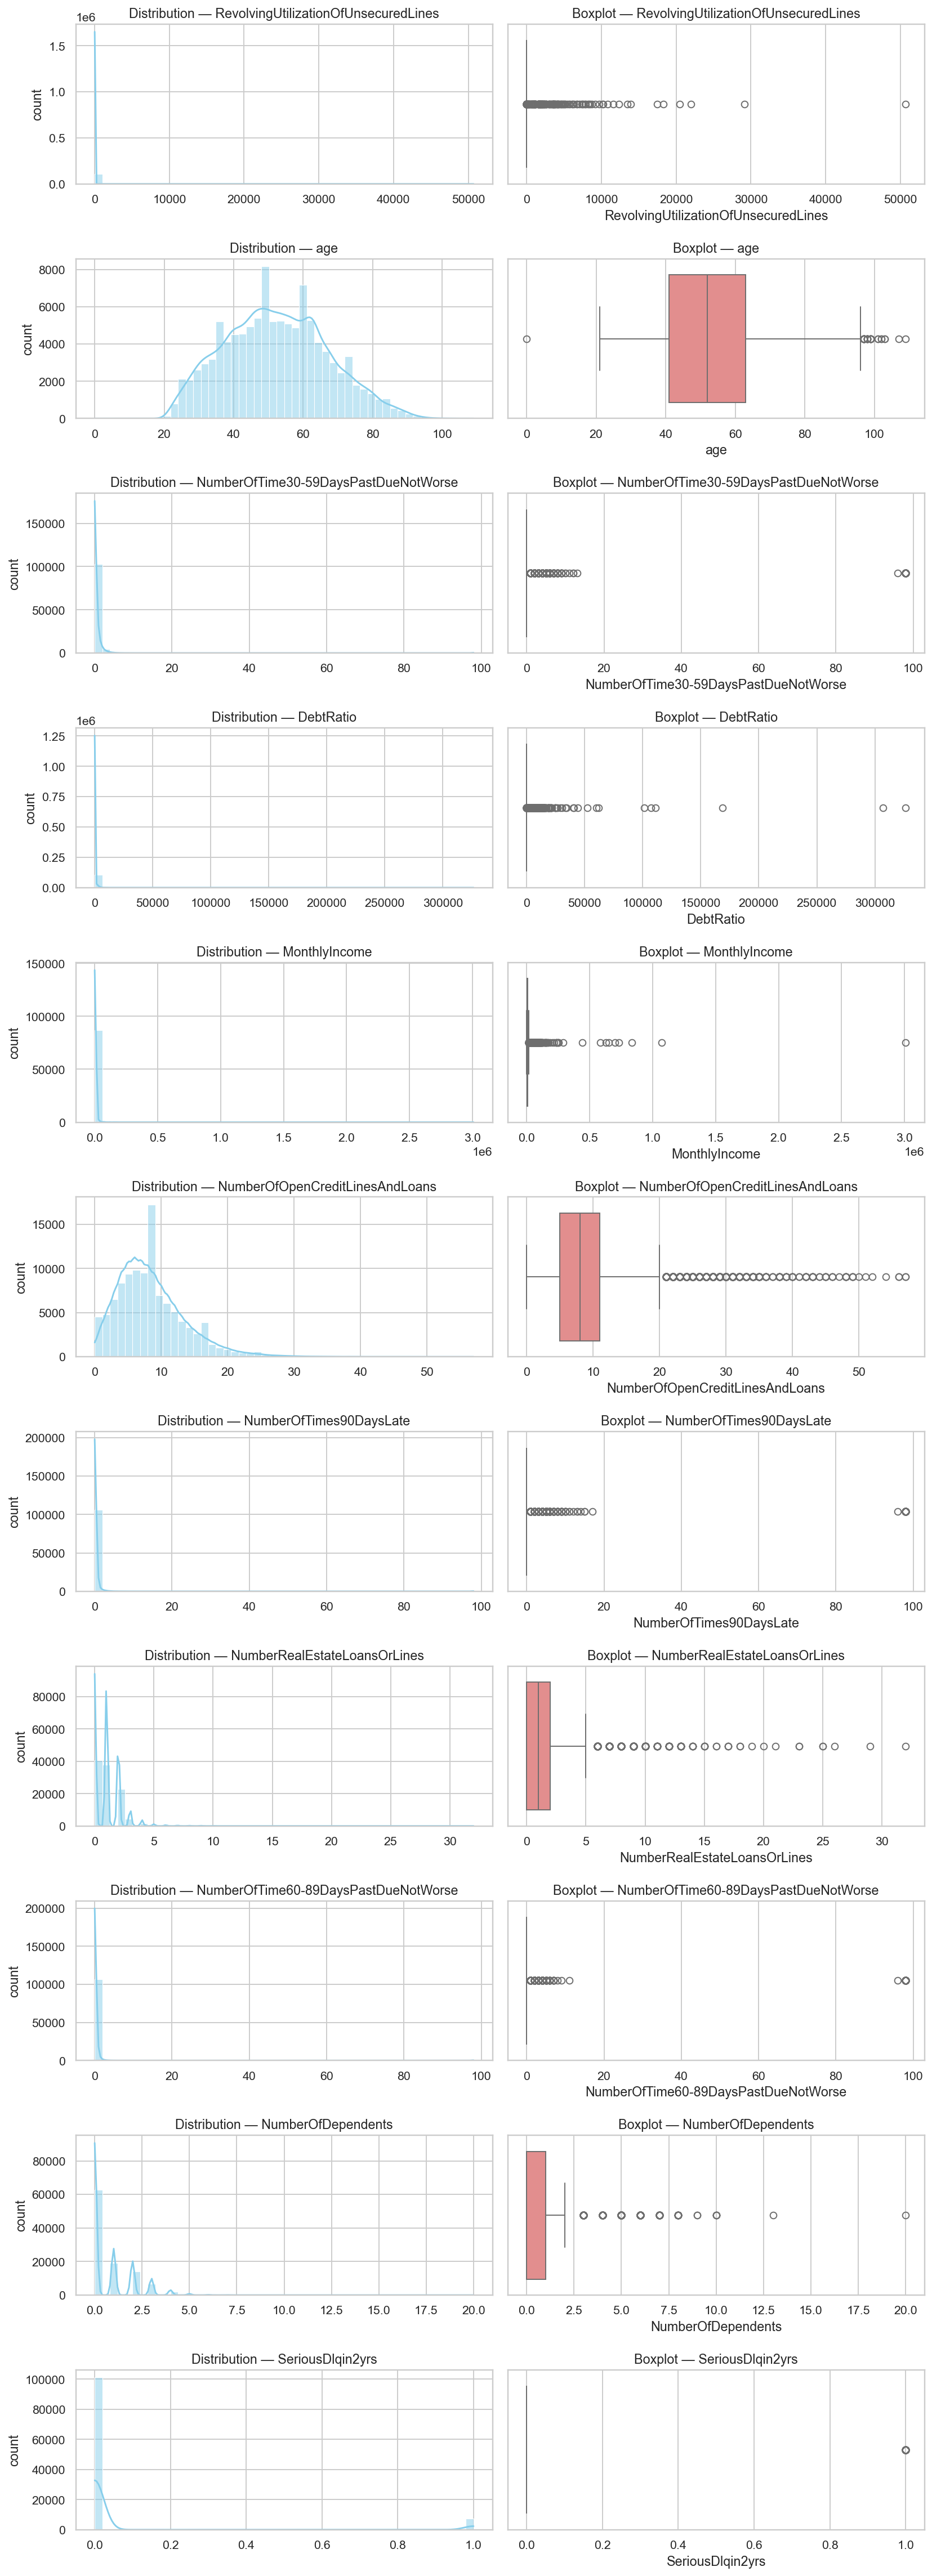

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Copy dataset to avoid modifying the original
plot_df = df_train.copy()

# Define numeric columns (all except target handled similarly)
cols = plot_df.columns

# Plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 140

# Grid layout
n_cols = 2
n_rows = len(cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))

for i, col in enumerate(cols):
    ax_hist = axes[i, 0]
    ax_box  = axes[i, 1]

    data = plot_df[col].dropna()

    # Histogram
    sns.histplot(data, bins=50, kde=True, ax=ax_hist, color="skyblue", edgecolor=None)
    ax_hist.set_title(f"Distribution — {col}")
    ax_hist.set_xlabel("")
    ax_hist.set_ylabel("count")

    # Boxplot
    sns.boxplot(x=data, ax=ax_box, color="lightcoral", orient="h")
    ax_box.set_title(f"Boxplot — {col}")
    ax_box.set_xlabel(col)

plt.tight_layout(h_pad=1.5)
plt.show()


## Preprocessing

- Median imputation for `MonthlyIncome` and `NumberOfDependents` + missing flags.
- Quantile winsorization (per-column 1%–99%) for heavy-tailed counts/ratios.
- Fixed clipping for `age` to [18, 100].
- `log1p` on strongly skewed positives: `RevolvingUtilizationOfUnsecuredLines`, `DebtRatio`, `MonthlyIncome`.
- Robust scaling on the final feature matrix.

All parameters are **fit on the training split only** and then applied to validation/test.

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ----- Custom transformers -----

class QuantileClipper(BaseEstimator, TransformerMixin):
    """Clip each column to [q_low, q_high] learned from the training data."""
    def __init__(self, low=0.01, high=0.99):
        self.low = low
        self.high = high

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.q_low_  = np.nanquantile(X, self.low,  axis=0)
        self.q_high_ = np.nanquantile(X, self.high, axis=0)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.q_low_, self.q_high_)

class ValueClipper(BaseEstimator, TransformerMixin):
    """Clip all values to fixed [min_val, max_val]."""
    def __init__(self, min_val=None, max_val=None):
        self.min_val = min_val
        self.max_val = max_val

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        if self.min_val is not None:
            X = np.maximum(X, self.min_val)
        if self.max_val is not None:
            X = np.minimum(X, self.max_val)
        return X

class RoundInt(BaseEstimator, TransformerMixin):
    """Round to nearest integer (useful after imputation)."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.rint(X)

# ----- Column groups (from training columns) -----

POS_SKEW = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "MonthlyIncome",        # impute → log1p
]

COUNT_COLS = [
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfTimes90DaysLate",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberRealEstateLoansOrLines",
]


AGE_COL = ["age"]
DEPENDENTS_COL = ["NumberOfDependents"]

# ----- Pipelines per block -----

pos_skew_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),        # for MonthlyIncome only; others pass through if no NaN
    ("quant_clip", QuantileClipper(low=0.01, high=0.99)),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", RobustScaler())
])

counts_pipe = Pipeline(steps=[
    ("quant_clip", QuantileClipper(low=0.01, high=0.99)),
    ("scaler", RobustScaler())
])

age_pipe = Pipeline(steps=[
    ("clip", ValueClipper(min_val=18, max_val=100)),
    ("scaler", RobustScaler())
])

dependents_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # median ~ 0
    ("round", RoundInt()),
    ("quant_clip", QuantileClipper(low=0.01, high=0.99)),
    ("scaler", RobustScaler())
])

# Missing indicators (kept separate so they don't go through log/scale of main pipes)
from sklearn.impute import MissingIndicator
miss_flags = ColumnTransformer(
    transformers=[
        ("miss_income", MissingIndicator(features="all"), ["MonthlyIncome"]),
        ("miss_deps",   MissingIndicator(features="all"), ["NumberOfDependents"]),
    ],
    remainder="drop",
)

# Main ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("pos",    pos_skew_pipe, POS_SKEW),
        ("counts", counts_pipe,   COUNT_COLS),
        ("age",    age_pipe,      AGE_COL),
        ("deps",   dependents_pipe, DEPENDENTS_COL),
        # the two indicators as separate blocks
        ("flags_income", MissingIndicator(features="all"), ["MonthlyIncome"]),
        ("flags_deps",   MissingIndicator(features="all"), ["NumberOfDependents"]),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ----- Fit on train only, transform all splits -----
FEATURES = POS_SKEW + COUNT_COLS + AGE_COL + DEPENDENTS_COL

X_train = df_train[FEATURES]
y_train = df_train[TARGET].astype(np.int64)

X_val   = df_val[FEATURES]
y_val   = df_val[TARGET].astype(np.int64)

X_test  = df_test[FEATURES]
y_test  = df_test[TARGET].astype(np.int64)

X_train_t = preprocess.fit_transform(X_train)
X_val_t   = preprocess.transform(X_val)
X_test_t  = preprocess.transform(X_test)

print("Transformed shapes:", X_train_t.shape, X_val_t.shape, X_test_t.shape)


Transformed shapes: (108375, 12) (19125, 12) (22500, 12)


## PyTorch data pipeline: tensors, `Dataset`, and `DataLoader`

- Convert transformed NumPy arrays to PyTorch tensors (`float32` for features, `int64` for labels).
- Wrap them in a minimal `Dataset` for tabular data.
- Create `DataLoader`s:
  - `shuffle=True` only for training.
  - A reasonable `batch_size` for stable updates.

Also compute class weights from the training labels for later use in the loss function.

In [51]:
# -- Tensors & DataLoaders --
X_train_np = X_train_t.astype(np.float32)
X_val_np   = X_val_t.astype(np.float32)
X_test_np  = X_test_t.astype(np.float32)

y_train_np = y_train.astype(np.int64).values
y_val_np   = y_val.astype(np.int64).values
y_test_np  = y_test.astype(np.int64).values

class TabularDataset(Dataset):
    """Thin dataset wrapper for numeric tabular data."""
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)  # [N, D] float32
        self.y = torch.from_numpy(y)  # [N]    int64

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instantiate datasets
train_ds = TabularDataset(X_train_np, y_train_np)
val_ds   = TabularDataset(X_val_np,   y_val_np)
test_ds  = TabularDataset(X_test_np,  y_test_np)

# DataLoaders
BATCH_SIZE = 256
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Sanity check: fetch one batch
xb, yb = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape, "| dtypes:", xb.dtype, yb.dtype)

# ---- Class imbalance weights (for loss) ----
n_pos = int((y_train_np == 1).sum())
n_neg = int((y_train_np == 0).sum())

# For BCEWithLogitsLoss: pos_weight multiplies positive examples' loss
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32)

# For CrossEntropyLoss with class weights: [w_neg, w_pos]
class_weights = torch.tensor([1.0, n_neg / n_pos], dtype=torch.float32)

print(f"n_neg={n_neg}, n_pos={n_pos}  |  pos_weight={float(pos_weight):.4f}  |  class_weights={class_weights.tolist()}")

Batch shapes: torch.Size([256, 12]) torch.Size([256]) | dtypes: torch.float32 torch.int64
n_neg=101131, n_pos=7244  |  pos_weight=13.9607  |  class_weights=[1.0, 13.960657119750977]


## Model & training setup

- Device selection (`cuda` if available).
- MLP for tabular data with BatchNorm and Dropout.
- Binary loss: `BCEWithLogitsLoss` using `pos_weight` (handles class imbalance).
- Optimizer: `AdamW`.

A quick forward pass on one batch to confirm shapes and loss.

In [69]:
device = DEVICE
# ---- Model ----
INPUT_DIM = X_train_t.shape[1]  # 12 after preprocessing (features) 
HIDDEN = [64, 32, 16]               # can tune later
DROPOUT = 0.2

class TabularMLP(nn.Module):
    def __init__(self, in_dim: int, hidden: list[int], dropout: float = 0.2):
        super().__init__()
        layers = []
        dims = [in_dim] + hidden # dims is a list containing the number of neurons of each layer that we will chain together.
        for i in range(len(dims) - 1): # 0 -> (len(dims) - 1) 
            layers += [
                nn.Linear(dims[i], dims[i+1]), # dense connection (linear combination of inputs)
                nn.BatchNorm1d(dims[i+1]),     # normalizes activations (improves stability)
                nn.GELU(),                     # non-linearity
                nn.Dropout(dropout),           # randomly drops neurons (regularization to prevent overfitting)
            ]
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(hidden[-1] if hidden else in_dim, 1)  # binary logit
        # careful weight initialization
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m: nn.Module):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(self.backbone) > 0:
            x = self.backbone(x)
        logit = self.head(x)  # shape [B, 1]
        return logit

model = TabularMLP(INPUT_DIM, HIDDEN, DROPOUT).to(device)

# ---- Loss ----
# use the pos_weight we computed earlier from y_train
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

# ---- Optimizer ----
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [70]:
# ---- Quick sanity forward (no training yet) ----
model.eval()
with torch.no_grad():
    xb, yb = next(iter(train_loader))           # one batch from DataLoader
    xb = xb.to(device)                          # [B, 12] float32
    yb = yb.to(device).float().unsqueeze(1)     # [B, 1] float32 (for BCEWithLogits)
    logits = model(xb)                          # [B, 1]
    loss = criterion(logits, yb)
    probs = torch.sigmoid(logits)               # convert to probabilities for inspection

print(f"Batch: xb={tuple(xb.shape)}, logits={tuple(logits.shape)}, loss={loss.item():.4f}")
print(f"Probs range: min={probs.min().item():.4f}, max={probs.max().item():.4f}")

Batch: xb=(256, 12), logits=(256, 1), loss=1.1915
Probs range: min=0.2576, max=0.9936


## Training loop (with validation, early stopping, and progress bar)

**Plan**
1. Train for `EPOCHS` with mini-batches from `train_loader`.
2. After each epoch, evaluate on `val_loader`.
3. Track the best `val_auc`; save the model when it improves.
4. Stop early if no improvement for `PATIENCE` epochs.
5. Use `BCEWithLogitsLoss(pos_weight=...)` to handle class imbalance.
6. Show a progress bar over batches for each epoch.

**Metrics**
- `loss` on train/val.
- `ROC-AUC` (+ `Average Precision`) on validation.

**Outputs**
- Prints epoch metrics.
- Saves best weights to `../models/tabular_mlp.pt`.


In [72]:
# Speed-ups tailored to GPU/CPU
USE_AMP = torch.cuda.is_available()               # mixed precision on GPU
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True         # auto-tune best kernels for shapes
    torch.set_float32_matmul_precision("high")    # faster matmul on Ada/Lovelace

# Hyperparameters
EPOCHS   = 30
PATIENCE = 5
LR       = 1e-3
WD       = 1e-4

# Re-create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

# ----------------------------- Early Stopping -----------------------------
class EarlyStopping:
    """Stop training when the monitored metric hasn't improved for 'patience' epochs."""
    def __init__(self, patience: int = 5, mode: str = "max"):
        self.patience = patience
        self.mode = mode
        self.best = -math.inf if mode == "max" else math.inf
        self.bad_epochs = 0
        self.should_stop = False

    def step(self, value: float) -> bool:
        improved = (value > self.best) if self.mode == "max" else (value < self.best)
        if improved:
            self.best = value
            self.bad_epochs = 0
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                self.should_stop = True
        return improved

# ----------------------------- Train One Epoch -----------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, use_amp=True):
    """Standard supervised training step over one full pass of 'loader'."""
    model.train()
    running_loss = 0.0
    scaler = torch.amp.GradScaler("cuda" ,enabled=use_amp)
    pbar = tqdm(loader, desc="train", leave=False)

    for xb, yb in pbar:
        xb = xb.to(device, non_blocking=True)                 # [B, D]
        yb = yb.to(device, non_blocking=True).float().unsqueeze(1)  # [B, 1]

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda",enabled=use_amp):        # AMP forward/backward
            logits = model(xb)                                # [B, 1] logits
            loss = criterion(logits, yb)                      # scalar loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * xb.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# ----------------------------- Evaluate (Val/Test) -----------------------------
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Compute loss and metrics on 'loader' without gradients."""
    model.eval()
    total_loss = 0.0
    all_probs, all_targets = [], []

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float().unsqueeze(1)

        logits = model(xb)
        loss = criterion(logits, yb)
        probs = torch.sigmoid(logits)                         # convert logits → probabilities

        total_loss += loss.item() * xb.size(0)
        all_probs.append(probs.squeeze(1).cpu())
        all_targets.append(yb.squeeze(1).cpu())

    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # Metrics (robust to edge cases)
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except Exception:
        auc = float("nan")
    try:
        ap = average_precision_score(all_targets, all_probs)
    except Exception:
        ap = float("nan")

    # Reference threshold 0.5
    preds = (all_probs >= 0.5).astype(int)
    acc = accuracy_score(all_targets, preds)
    f1  = f1_score(all_targets, preds, zero_division=0)

    return {
        "loss": total_loss / len(loader.dataset),
        "auc": auc,
        "ap": ap,
        "acc": acc,
        "f1": f1,
    }

# ----------------------------- Training Loop -----------------------------
early = EarlyStopping(patience=PATIENCE, mode="max")
best_path = os.path.join(MODEL_PATH, "tabular_mlp.pt")

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, use_amp=USE_AMP)
    val_metrics = evaluate(model, val_loader, criterion, device)

    msg = (
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_metrics['loss']:.4f} | "
        f"val_auc={val_metrics['auc']:.4f} | "
        f"val_ap={val_metrics['ap']:.4f} | "
        f"val_acc={val_metrics['acc']:.4f} | "
        f"val_f1={val_metrics['f1']:.4f}"
    )
    print(msg)

    # Early stopping on validation AUC (maximize)
    if early.step(val_metrics["auc"]):
        torch.save({
            "model_state_dict": model.state_dict(),
            "input_dim": INPUT_DIM,
            "hidden": HIDDEN,
            "dropout": DROPOUT,
        }, best_path)
        print(f"✓ Saved new best to: {best_path} (val_auc={val_metrics['auc']:.4f})")

    if early.should_stop:
        print(f"Early stopping triggered (patience={PATIENCE}).")
        break

print("\nTraining finished.")


Epoch 1/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8827 | val_loss=0.8503 | val_auc=0.8689 | val_ap=0.3824 | val_acc=0.8021 | val_f1=0.3437
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8689)

Epoch 2/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8829 | val_loss=0.8455 | val_auc=0.8698 | val_ap=0.3847 | val_acc=0.7822 | val_f1=0.3301
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8698)

Epoch 3/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8868 | val_loss=0.8467 | val_auc=0.8696 | val_ap=0.3844 | val_acc=0.7896 | val_f1=0.3355

Epoch 4/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8835 | val_loss=0.8483 | val_auc=0.8690 | val_ap=0.3836 | val_acc=0.7870 | val_f1=0.3330

Epoch 5/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8815 | val_loss=0.8499 | val_auc=0.8688 | val_ap=0.3828 | val_acc=0.7993 | val_f1=0.3419

Epoch 6/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8840 | val_loss=0.8478 | val_auc=0.8693 | val_ap=0.3833 | val_acc=0.7846 | val_f1=0.3303

Epoch 7/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8820 | val_loss=0.8453 | val_auc=0.8701 | val_ap=0.3864 | val_acc=0.7832 | val_f1=0.3310
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8701)

Epoch 8/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8831 | val_loss=0.8495 | val_auc=0.8697 | val_ap=0.3859 | val_acc=0.8040 | val_f1=0.3452

Epoch 9/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8809 | val_loss=0.8478 | val_auc=0.8696 | val_ap=0.3862 | val_acc=0.7924 | val_f1=0.3372

Epoch 10/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8823 | val_loss=0.8464 | val_auc=0.8699 | val_ap=0.3870 | val_acc=0.7955 | val_f1=0.3395

Epoch 11/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8820 | val_loss=0.8476 | val_auc=0.8694 | val_ap=0.3848 | val_acc=0.7915 | val_f1=0.3354

Epoch 12/30


train:   0%|          | 0/424 [00:00<?, ?it/s]

train_loss=0.8809 | val_loss=0.8494 | val_auc=0.8696 | val_ap=0.3853 | val_acc=0.7955 | val_f1=0.3392
Early stopping triggered (patience=5).

Training finished.


Loaded best checkpoint from: ../models\tabular_mlp.pt
TEST | loss=0.8452 | auc=0.8702 | ap=0.4006 | acc=0.7806 | f1=0.3282

Confusion Matrix @0.5 (rows=true, cols=pred)
[[16357  4639]
 [  298  1206]]
TN=16357  FP=4639  FN=298  TP=1206

Classification report @0.5
              precision    recall  f1-score   support

         0.0     0.9821    0.7791    0.8689     20996
         1.0     0.2063    0.8019    0.3282      1504

    accuracy                         0.7806     22500
   macro avg     0.5942    0.7905    0.5985     22500
weighted avg     0.9303    0.7806    0.8327     22500



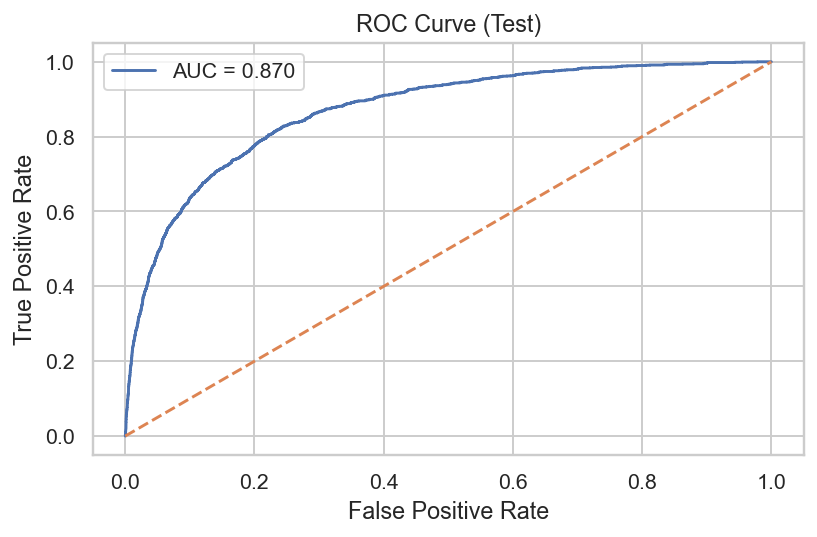

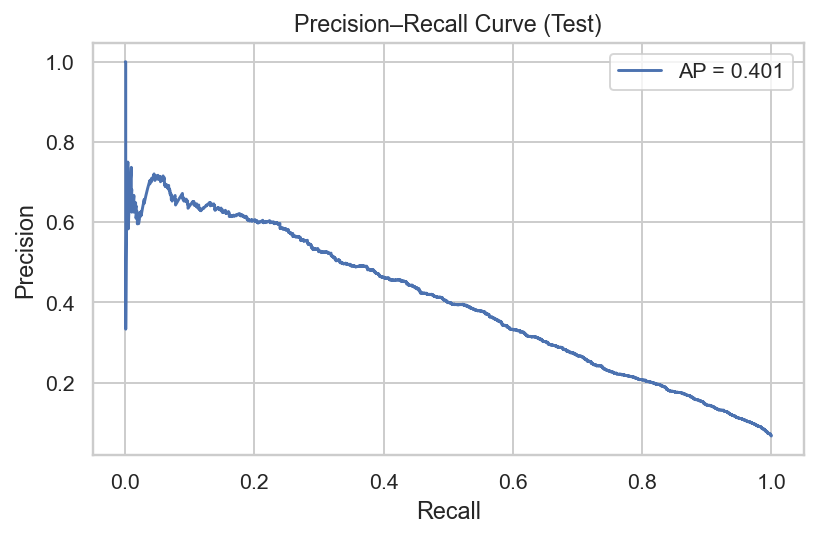

In [74]:
# =========================
# Test evaluation & plots
# =========================
# 1) Load best checkpoint
best_path = os.path.join(MODEL_PATH, "tabular_mlp.pt")
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.to(device).eval()
    print(f"Loaded best checkpoint from: {best_path}")
else:
    model.eval()
    print("Best checkpoint not found; evaluating current model in memory.")

# 2) Evaluate on the test set (loss + metrics)
test_metrics = evaluate(model, test_loader, criterion, device)
print(
    f"TEST | "
    f"loss={test_metrics['loss']:.4f} | "
    f"auc={test_metrics['auc']:.4f} | "
    f"ap={test_metrics['ap']:.4f} | "
    f"acc={test_metrics['acc']:.4f} | "
    f"f1={test_metrics['f1']:.4f}"
)

# 3) Get probabilities and targets for detailed analysis
@torch.no_grad()
def get_probs_and_targets(model, loader, device):
    model.eval()
    all_probs, all_targets = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float().unsqueeze(1)
        logits = model(xb)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(yb.squeeze(1).cpu().numpy())
    return np.concatenate(all_probs), np.concatenate(all_targets)

test_probs, test_y = get_probs_and_targets(model, test_loader, device)

# 4) Confusion matrix at threshold 0.5
thr = 0.5
test_pred = (test_probs >= thr).astype(int)
cm = confusion_matrix(test_y, test_pred, labels=[0, 1])  # rows=true, cols=pred
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix @0.5 (rows=true, cols=pred)")
print(cm)
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")

print("\nClassification report @0.5")
print(classification_report(test_y, test_pred, digits=4))

# 5) ROC and PR curves
fpr, tpr, _ = roc_curve(test_y, test_probs)
prec, rec, _ = precision_recall_curve(test_y, test_probs)

# ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_metrics['auc']:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall curve
plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label=f"AP = {test_metrics['ap']:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()